<a href="https://colab.research.google.com/github/HimashiRathnayake/Hate-Speech-Humor-Detection/blob/main/Baselines/CNN_RNN/Humor_Hate_Speech_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Hate Speech Detection & Humor Detection for Code-mixed Sinhala-English Data </h1>

# User Parameters

In [ ]:
Host = "colab" #@param ["colab", "AWS", "GCP"]
technique = "humor" #@param ["humor", "hate speech"]

EMBEDDING_SIZE = 300 #@param [50, 150, 200, 250, 300, 350, 400, 450, 500]
embedding_type = "fasttext" #@param ["fasttext","word2vec"]
experiment_no = "801" #@param [] {allow-input: true}
model_type = "LSTM" #@param ["RNN","GRU", "LSTM", "BiLSTM"]
over_sampling_technique = "ROS" #@param ["", "ROS","ADASYN", "SMOTE", "BorderlineSMOTE"]
sampling_strategy = "0.5" #@param [] {allow-input: true}

stack_modeles = "" #@param ["","2","3"]
apply_CNN = False #@param {type:"boolean"}
apply_TPU_support = True #@param {type:"boolean"}

model_name = model_type + "_model"
if(stack_modeles == "2" or stack_modeles == "3"):
  model_name = "stacked_" + model_name + "_" + stack_modeles
if(apply_CNN):
  model_name = "CNN_" + model_name

if technique == "humor" :
  NO_OUTPUT_LAYERS = 2
  tag_set = ["Humorous", "Non-Humorous"]
elif technique == "hate speech":
  NO_OUTPUT_LAYERS = 3
  tag_set = ["Abusive", "Hate-Inducing", "Not offensive"]

print(model_name + " for " + technique + " detection")

LSTM_model for humor detection


# Folder Paths

In [ ]:
folder_path = "/content/drive/Shareddrives/FYP/"
data_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Annotations/Final/All_tagged_data/çompleted_draft.csv"

context = 5
word_embedding_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
word_embedding_keydvectors_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/keyed_vectors/" +  "embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
embedding_matrix_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Humor_HateSpeech detection/Implementation/embedding_matrix/"+embedding_type+'_'+str(EMBEDDING_SIZE)

experiment_name = str(experiment_no) + "_"+ model_name +"_"+embedding_type+"_"+str(EMBEDDING_SIZE)+"_"+str(context)
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/"+technique+"/"+experiment_name+".hdf5"

# Dependencies

In [ ]:
# # !pip uninstall keras-nightly
# !pip uninstall -y tensorflow
# !pip install h5py==2.10.0  
# !pip install tensorflow==1.15.2
# !pip install q keras==2.3.1

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 110.5 MB 22 kB/s 
     |████████████████████████████████| 503 kB 59.0 MB/s 
     |████████████████████████████████| 3.8 MB 41.9 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=29b27579a0e5383e303621c92b68c3ec2d56df3ac9e7475ba6ac3ae65428c98b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uni

In [ ]:
f0rom __future__ import print_function

import collections
import pickle
import re
import random
import sys
import os 
import time

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.fasttext import FastText
from gensim.models import word2vec

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, make_scorer

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import cumsum

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras import backend as K
from keras.models import Sequential,Model,load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Add,TimeDistributed, Bidirectional,SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2, l1_l2
from keras.constraints import maxnorm
from keras import callbacks
from keras.utils import generic_utils,plot_model
from keras.optimizers import Adadelta, Adam, SGD, RMSprop, Adagrad, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from google.colab import data_table
from google.colab import drive

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Add TPU Support**

In [ ]:
if (apply_TPU_support):

  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  # tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 1.15.2
Running on TPU  ['10.77.189.194:8470']
INFO:tensorflow:Querying Tensorflow master (grpc://10.77.189.194:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10385720972914234476)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6152022973718950811)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2644888452023333145)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 536836756415925071)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 12445876435619671886)

# Load Data

In [ ]:
all_data = pd.read_csv(data_path)

if (technique == "humor"):
  all_data = all_data[['Sentence', 'Humor']]
elif (technique == "hate speech"):
  all_data = all_data[['Sentence', 'Hate_speech']]
else:
  all_data = all_data[['Sentence', 'Offensive']]

all_data.columns = ['Sentence', 'Label']
data_table.DataTable(all_data, include_index=False, num_rows_per_page=10)

,Sentence,Label
0,Ammage Adarayta❤️Eka Dawasak Madi Neda❤️🙏❤️,Non-humorous
1,We need IPL Champions leak data offers ..pleas...,Non-humorous
2,#VPN #ummmaaa #proud_be,Non-humorous
3,chandimal.. uuu thama mulu tem ekama kaaa gaha...,Non-humorous
4,sltgo,Non-humorous
...,...,...
13513,Me mase web family plus packge eke total eka 6...,Non-humorous
13514,munge Dan data kapana widiye awulk thiyenwa,Non-humorous
13515,I didn't received loyalty data past months. Pl...,Non-humorous
13516,worst service ever!!! stolen more than 10GB fr...,Non-humorous


In [ ]:
output_labels = all_data['Label'].unique()
print('Output Labels:', output_labels)

label_group =  all_data.groupby('Label')['Label'].count()
print(label_group)

Output Labels: ['Non-humorous' 'Humorous']
Label
Humorous         1305
Non-humorous    12213
Name: Label, dtype: int64


# Create Input

## Comment-label split

In [ ]:
def text_preprocessing(data):
  comments = data['Sentence']
  labels = data['Label']

  comments_splitted = []

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)

  return comments_splitted,labels

## Takenize and Split Data

In [ ]:
comment_texts, comment_labels = text_preprocessing(all_data)

# prepare tokenizer

t = Tokenizer()
t.fit_on_texts(comment_texts)
vocab_size = len(t.word_index) + 1
print(vocab_size)

28401


In [ ]:
encoded_docs = t.texts_to_sequences(comment_texts)

In [ ]:
max_length = len(max(encoded_docs, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length)
comment_labels = np.array(comment_labels)
padded_docs = np.array(padded_docs)

In [ ]:
comment_labels = pd.get_dummies(comment_labels).values
print('Shape of label tensor:', comment_labels.shape)

Shape of label tensor: (13518, 2)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=0.1, random_state=0)

## Oversampling

In [ ]:
def apply_oversampling(x, y):

  (unique, counts) = np.unique(y, axis=0, return_counts=True)
  print("Class Distribution Without Oversampling", counts)

  # define oversampling strategy
  if (over_sampling_technique == ""):
    return x, y
  elif (over_sampling_technique == "ROS"):
    if (technique=="humor"):
      oversample = RandomOverSampler(sampling_strategy = float(sampling_strategy))
    else:
      sampling_ratio = sampling_strategy.split(":");
      oversample = RandomOverSampler(ratio = {
          0:int(counts[0]*float(sampling_ratio[0])), 
          1:int(counts[0]*float(sampling_ratio[1])), 
          2:int(counts[0]*float(sampling_ratio[2]))
          })
  elif (over_sampling_technique == "ADASYN"):
    oversample = ADASYN(sampling_strategy="minority")
  elif (over_sampling_technique == "SMOTE"):
    oversample = SMOTE()
  elif (over_sampling_technique == "BorderlineSMOTE"):
    oversample = BorderlineSMOTE()

  # fit and apply the transform
  X_over, y_over = oversample.fit_resample(x, y)
  if(technique=="humor"):
    y_over = pd.get_dummies(y_over.flatten())

  (unique, counts) = np.unique(y_over, axis=0, return_counts=True)
  print("Class Distribution After Oversampling", counts)

  return X_over, y_over

# Word Embedding

## Generate Embedding Metrix

In [ ]:
def generate_embedding_metrix():
  if (embedding_type == 'fasttext'):
    word_embedding_model = FastText.load(word_embedding_path)
  else:
    word_embedding_model = word2vec.Word2Vec.load(word_embedding_path)
    
  word_vectors = word_embedding_model.wv
  word_vectors.save(word_embedding_keydvectors_path)
  word_vectors = KeyedVectors.load(word_embedding_keydvectors_path, mmap='r')

  embeddings_index = dict()
  for word, vocab_obj in word_vectors.vocab.items():
    embeddings_index[word]=word_vectors[word]

  # create a weight matrix for words in training docs
  embedding_matrix = zeros((vocab_size, EMBEDDING_SIZE))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  pickle.dump(embedding_matrix, open(embedding_matrix_path, 'wb'))
  return embedding_matrix

## Load Embedding Matrix

In [ ]:
def load_word_embedding_matrix():
  f = open(embedding_matrix_path, 'rb')
  embedding_matrix= np.array(pickle.load(f))
  return embedding_matrix

# Models

## RNN(LSTM/GRU) model

In [ ]:
def RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2, optimizer="Adadelta"):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims)(embedding)

    x = Dense(hidden_dims, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    if optimizer == "Adadelta":
        optimizer = Adadelta(lr=0.95, epsilon=1e-06)

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer = optimizer,
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       f1
                       ])
    
    print(model.summary())
    return model

def stacked_RNN_model_2(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "stacked_RNN_model_2")

    model.compile(loss={'output':'categorical_crossentropy'},
          optimizer=Adadelta(lr=0.95, epsilon=1e-06),
          metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                       f1])

    print(model.summary())
    return model

def stacked_RNN_model_3(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims,return_sequences=True)(x)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name="stacked_RNN_model_3")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    print(model.summary())
    return model

## CNN+RNN(LSTM /GRU) model 

In [ ]:
def CNN_RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    conv4 = Convolution1D(NB_FILTERS,
                          4,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv4')(embedding)
    maxConv4 = MaxPooling1D(pool_length=2,
                             name='maxConv4')(conv4)

    conv5 = Convolution1D(NB_FILTERS,
                          5,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv5')(embedding)
    maxConv5 = MaxPooling1D(pool_length=2,
                            name='maxConv5')(conv5)

    x = keras.layers.Concatenate(axis=1)([maxConv4, maxConv5])

    x = Dropout(drop_out_value_2)(x)

    x = RNN_layer(hidden_dims)(x) #rnn_output_size


    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "CNN+RNN model")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    return model

## BiLSTM model 

In [ ]:
def BiLSTM_model(maxlen, hidden_dims, l2_reg, drop_out_value_1, optimizer="Adam", learning_rate=0.001):
  input = Input(shape=(maxlen,))
  embedding = Embedding(MAX_FEATURES, EMBEDDING_SIZE, weights=[EMBEDDING_MATRIX], input_length=maxlen)(input)

  model =  Bidirectional (LSTM (hidden_dims, return_sequences=True, dropout=drop_out_value_1, kernel_regularizer=l2(0.01)), merge_mode='concat')(embedding)
  model = TimeDistributed(Dense(hidden_dims, activation='relu'))(model)
  model = Flatten()(model)
  # model = Dense(hidden_dims, activation='relu')(model) # extra dense layer
  output = Dense(NO_OUTPUT_LAYERS, activation='softmax', name='output')(model)
  model = Model(input, output)

  if optimizer == 'SGD':
        optimizer = SGD(learning_rate=learning_rate)
  elif optimizer == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer == 'Adagrad':
      optimizer = Adagrad(learning_rate=learning_rate)
  elif optimizer == "Adadelta":
      optimizer = Adadelta(lr=learning_rate, epsilon=1e-06)
  elif optimizer == "Adam":
      optimizer = Adam(lr=learning_rate)
  elif optimizer == "Adamax":
      optimizer = Adamax(lr=learning_rate)
  else:
      optimizer = Nadam(learning_rate=learning_rate)

  model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=optimizer,
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                f1])
  
  return model

# Train and Evaluate Model

## Custom F1 Implementation

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Macro Averages Callback Implementation

In [ ]:
class MacroMetrics(Callback):
    def __init__(self, valid_data):
        super(MacroMetrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_macro_f1'] = _val_f1
        logs['val_macro_recall'] = _val_recall
        logs['val_macro_precision'] = _val_precision
        print("val_macro_precision: %f - val_macro_recall: %f - val_macro_f1: %f" % (_val_precision, _val_recall, _val_f1))
        return

## Train and Validate model

In [ ]:
def Train_Model(model, X_train, y_train, cross_validation = False, epochs=10):

  print('Training and Testing...')

  x_train_train, x_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=0)

  X_over, y_over = apply_oversampling(x_train_train, y_train_train);

  es = EarlyStopping(monitor='val_macro_f1', mode='max', verbose=1, patience=5)
  checkpoint = ModelCheckpoint(model_save_path, monitor='val_macro_f1', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), checkpoint , es]

  if (cross_validation):
    callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), es]

  his = model.fit(X_over, y_over, validation_data=[x_val, y_val], epochs=epochs, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
  return model, his

# Cross Validation

In [ ]:
def Do_Cross_Validation(X,y):

  # Define per-fold score containers
  loss_per_fold = []
  acc_per_fold = []
  precision_per_fold = []
  recall_per_fold = []
  f1_per_fold = []

  macro_f1_per_fold = []
  macro_precision_per_fold = []
  macro_recall_per_fold = []

  kfold = KFold(n_splits=FOLDS, shuffle=True)

  fold_no = 1
  inputs = X
  targets = y
  
  for train, test in kfold.split(inputs, targets):

    model = build_model()
    # model = RNN_model(GRU, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    
    # RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model, his = Train_Model(model, inputs[train], targets[train], cross_validation=True)
 
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    y_val_pred = model.predict(inputs[test])
    y_val_pred_cat = (np.asarray(y_val_pred)).round()
    y_val = targets[test]

    # Get performance metrics(macro averages) after each fold
    macro_f1, macro_precision, macro_recall = f1_score(y_val, y_val_pred_cat, average='macro'), precision_score(y_val, y_val_pred_cat, average='macro'), recall_score(y_val, y_val_pred_cat, average='macro')

    print(f"""Score for fold {fold_no}:
     {model.metrics_names[0]} of {scores[0]}; 
     {model.metrics_names[1]} of {scores[1]*100}% ;
     {model.metrics_names[2]} of {scores[2]*100}% ;
     {model.metrics_names[3]} of {scores[3]*100}% ;
     {model.metrics_names[4]} of {scores[4]*100}% ;
     macro precision of {macro_precision*100}% ;
     macro recall of {macro_recall*100}% ;
     macro f1 of {macro_f1*100}% ;
     """)
    
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    f1_per_fold.append(scores[4])

    macro_f1_per_fold.append(round(macro_f1, 6))
    macro_precision_per_fold.append(round(macro_precision, 6))
    macro_recall_per_fold.append(round(macro_recall, 6))

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f"""> Fold {i+1} - 
    Loss: {loss_per_fold[i]} - 
    Accuracy: {acc_per_fold[i]}% - 
    Precesion: {precision_per_fold[i]}% - 
    Recall: {recall_per_fold[i]}% - 
    F1: {f1_per_fold[i]}%
    Macro Precision: {macro_precision_per_fold[i]}%
    Macro Recall: {macro_recall_per_fold[i]}%
    Macro F1: {macro_f1_per_fold[i]}%
    """)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Precision: {np.mean(precision_per_fold)}')
  print(f'> Recall: {np.mean(recall_per_fold)}')
  print(f'> F1: {np.mean(f1_per_fold)}')
  print(f'> Macro Precision: {np.mean(macro_precision_per_fold)}')
  print(f'> Macro Recall: {np.mean(macro_recall_per_fold)}')
  print(f'> Macro F1: {np.mean(macro_f1_per_fold)}')
  print('------------------------------------------------------------------------')

# Plot Graphs

In [ ]:
def Plot_graphs(metric,val_metric,metric_name):

  epochs=range(len(metric)) # Get number of epochs

  if metric_name == "accuracy":
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()

  elif metric_name == "loss" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()

  elif metric_name == "f1" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation F1')
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(["F1", "Validation F1"])

    plt.figure()


  # Expected Output
  # A chart where the validation loss does not increase sharply!

# Main Method

## Set Hyper-Parameters

In [ ]:
# EMBEDDING_MATRIX = generate_embedding_metrix()
EMBEDDING_MATRIX = load_word_embedding_matrix()

In [ ]:
# 'drop_out_value_1': 0.7, 'drop_out_value_2': 0.3, 'hidden_dims': 600, 'learning_rate': 0.001, 'optimizer': 'Adam'
MAX_FEATURES = EMBEDDING_MATRIX.shape[0] #vocab_size
VERBOSITY = 1
VALIDATION_SPLIT = 0.1
NB_EPOCHS = 10
FOLDS = 5 #10

BATCH_SIZE = 32 # 64, 128
NB_FILTERS = 200
FILTER_LENGTH = 4 # test with 2,3,4,5
HIDDEN_DIMS = 400 # 400
MAX_LEN = max_length #275
DROPOUT_VALUE_1 = 0.7 #0.5 #0.8 #0.3
DROPOUT_VALUE_2 = 0.8
L2_REG= 0.01
OPTIMIZER = 'Adadelta' # 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
LR = 0.005 # initial - 0.95 | humor - 0.002

RNN = GRU

## Build and Compile Model

In [ ]:
def build_model() :
  model = None

  if (model_type == "RNN" or model_type == "GRU" or model_type == "LSTM" ):
    # configure layer
    layer = None
    if (model_type == "RNN"):
      layer = RNN
    if (model_type == "GRU"):
      layer = GRU
    if (model_type == "LSTM"):
      layer = LSTM
    
    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_RNN_model_2(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_RNN_model_3(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = RNN_model(layer, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2, OPTIMIZER)

  elif (model_type == "BiLSTM" ):

    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_BiLSTM_model_2(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_BiLSTM_model_3(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

    
  return model

## Train and Test Model (Holdout Method)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

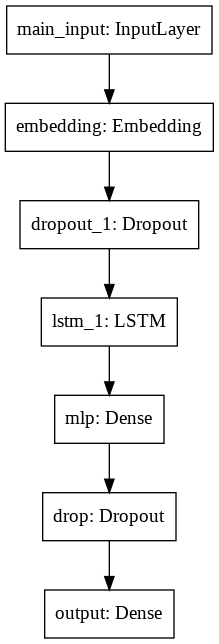

In [ ]:
if (apply_TPU_support):
  with tpu_strategy.scope():
    model = build_model()
else:
  model = build_model()
# model = stacked_RNN_model_3(LSTM, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
plot_model(model,to_file="./model.png")

### Train Model

In [ ]:
# trained_model = Train_Model_old(model,X_train, X_test, y_train, y_test)
if (apply_TPU_support):

  trained_model, his = Train_Model(model, X_train, y_train, cross_validation = False)

  accuracy = his.history['accuracy']
  val_accuracy = his.history['val_accuracy']
  loss = his.history['loss']
  val_loss = his.history['val_loss']
  f1 = his.history['f1']
  val_f1 = his.history['f1']
  val_macro_f1 = his.history['val_macro_f1']

  Plot_graphs(accuracy,val_accuracy, "accuracy")
  Plot_graphs(loss,val_loss, "loss")
  Plot_graphs(f1, val_f1, "f1")

Training and Testing...
Class Distribution Without Oversampling [9898 1051]
Class Distribution After Oversampling [9898 4949]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train on 14847 samples, validate on 1217 samples


KeyboardInterrupt: ignored

### Restart runtime and import Relibraries
There is a bug, if run time isn't restart after this point, It's going to malfunction.

In [ ]:
# #os.kill(os.getpid(), 9)
# exit()

In [ ]:
# from keras.models import Sequential,Model,load_model
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

# experiment_no = 100
# model_name = "RNN"
# experiment_name = folder_path + "Sentiment Analysis/CNN RNN/experiments/" + model_name +str(experiment_no)+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(context)

# model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/weights_best_"+model_name+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(experiment_no)+".hdf5"

### Test Model

#### Load Weights to Model

In [ ]:
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/" + technique + "/"+ experiment_no +"_" + model_type + "_model_fasttext_300_5.hdf5"
# model_save_path = "/content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/hate speech/06_BiLSTM_model_fasttext_300_5.hdf5"

print("Load model from "+model_save_path)
loaded_model  = keras.models.load_model(model_save_path, custom_objects={"f1": f1}, compile=False)
print("loaded " + loaded_model.name)

# _, train_acc,train_f1 = loaded_model.evaluate(X_train, y_train, verbose=1)
# _, test_acc,test_f1= loaded_model.evaluate(X_test, y_test, verbose=1)
# print('Train_acc: %.3f, Test_acc: %.3f, Train_f1: %.3f,  Test_f1: %.3f' % (train_acc, test_acc,train_f1,test_f1))

Load model from /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/humor/101_LSTM_model_fasttext_300_5.hdf5
loaded RNN_model


#### Get Predictions

In [ ]:
predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

labels = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels,predictions )

# classification_report
report = classification_report(labels, predictions, digits=4,output_dict=True)
report_print = classification_report(labels, predictions, digits=4)
print(report_print)

# save report to drive
report_save_path = folder_path + "Humor_HateSpeech detection/Implementation/reports/"+model_name+"_"+technique+"_"+ experiment_no+"_report.csv"
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(report_save_path)

1352/1352 [==============================] - 23s 17ms/step
              precision    recall  f1-score   support

           0     0.4138    0.4511    0.4317       133
           1     0.9395    0.9303    0.9349      1219

    accuracy                         0.8831      1352
   macro avg     0.6767    0.6907    0.6833      1352
weighted avg     0.8878    0.8831    0.8854      1352



In [ ]:
train_data_original, test_data_original = train_test_split(all_data, test_size=0.1, random_state=0)

predictions_series = pd.Series(predictions)
predictions_1 = pd.get_dummies(predictions_series).idxmax(1)

In [ ]:
data_frame = pd.DataFrame({'Sentence': test_data_original['Sentence'], 'Label': test_data_original['Label'], 'Predictions': np.array(predictions_1)})

def apply_label_name(value):
  return tag_set[value]

data_frame["Predictions"] = data_frame["Predictions"].apply(apply_label_name)

prediction_save_name  = folder_path + "Humor_HateSpeech detection/Implementation/predictions/"+model_name+"_"+technique+"_"+ experiment_no+"_predictions_with_labels.csv"
data_frame.to_csv(prediction_save_name)
data_table.DataTable(data_frame, include_index=False, num_rows_per_page=10)

,Sentence,Label,Predictions
12114,මේක තමයි හොඳම වංචාව.,Non-humorous,Non-Humorous
3505,frree da,Non-humorous,Non-Humorous
13156,Alawwata gendoooo,Non-humorous,Non-Humorous
2364,Balummhara fiber diyan labba,Non-humorous,Non-Humorous
1136,Enjoy good times streaming with the Automatic ...,Non-humorous,Non-Humorous
...,...,...,...
9997,නැතහොත් SLT පාරිභෝගිකයන් ඉක්මනින් වෙනත් ආයතනයක...,Non-humorous,Non-Humorous
16,හොඳ වැඩේ....මෙයැයිලගේ හැටි දන්නෑ ඔයැයිලා....❤️...,Humorous,Humorous
578,Now I bought 1Gb but free 1 Gb is not there??,Non-humorous,Non-Humorous
2305,හරීම ලස්සනයි මෙහෙම හොද පුතාලත් ලෝකයේ ඉන්නවා,Non-humorous,Non-Humorous


### Print confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

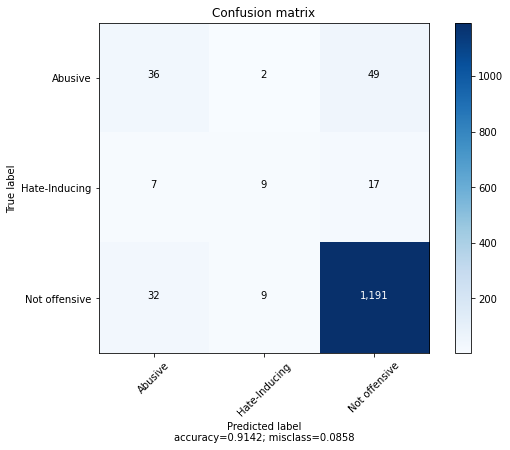

In [ ]:
if (technique=="humor"):
  plot_confusion_matrix(cm, ["Humorous","Non humorous"], normalize=False)
else:  
  plot_confusion_matrix(cm, ["Abusive","Hate-Inducing","Not offensive"], normalize=False)

## Train and Test Model (Cross Validation)

In [ ]:
with tpu_strategy.scope():
  Do_Cross_Validation(padded_docs, comment_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_2 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train on 13186 samples, validate on 1082 samples
Epoch 1/10
13186/13186 [==============================] - 622s 47ms/step - loss: 0.5492 - accuracy: 0.7340 - precision_1: 0.7037 - recall_1: 0.7037 - f1: 0.7323 - val_loss: 0.3649 - val_accuracy: 0.8420 - val_precision_1: 0.7382 - val_recall_1: 0.7382 - val_f1: 0.8420
val_macro_precision: 0.622245 - val_macro_recall: 0.682980 - val_macro_f1: 0.641599
Epoch 2/10
13186/13186 [==============================] - 640s 49ms/step - loss: 0.4517 - accuracy: 0.7845 - precision_1: 0.7540 - recall_1: 0.7540 - f1: 0.7839 - val_loss: 0.4045 - val_accuracy: 0.8078 - val_precision_1: 0.7636 - val_recall_1: 0.7636 - val_f1: 0.8071
val_macro_precision: 0.580952 - val_macro_recall: 0.634294 - val_macro_f1: 0.592974
Epoch 3/10
13186/13186 [==============================] - 638s 48ms/step - loss: 0.3945 - accuracy: 0.8157 - precision_1: 0.7724 - recall_1: 0.7724 - f1: 0.8161 - val_loss: 0.4177 - val_accuracy: 0.7967 - val_precision_1: 0.7806 - val_recall_1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_3 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13144 samples, validate on 1082 samples
Epoch 1/10
13144/13144 [==============================] - 636s 48ms/step - loss: 0.5507 - accuracy: 0.7309 - precision_2: 0.7078 - recall_2: 0.7078 - f1: 0.7309 - val_loss: 0.4100 - val_accuracy: 0.7800 - val_precision_2: 0.7326 - val_recall_2: 0.7326 - val_f1: 0.7804
val_macro_precision: 0.577396 - val_macro_recall: 0.663151 - val_macro_f1: 0.584759
Epoch 2/10
13144/13144 [==============================] - 638s 49ms/step - loss: 0.4630 - accuracy: 0.7766 - precision_2: 0.7456 - recall_2: 0.7456 - f1: 0.7765 - val_loss: 0.3843 - val_accuracy: 0.8050 - val_precision_2: 0.7556 - val_recall_2: 0.7556 - val_f1: 0.8054
val_macro_precision: 0.586196 - val_macro_recall: 0.663089 - val_macro_f1: 0.599540
Epoch 3/10
13144/13144 [==============================] - 640s 49ms/step - loss: 0.4050 - accuracy: 0.8066 - precision_2: 0.7645 - recall_2: 0.7645 - f1: 0.8066 - val_loss: 0.3538 - val_accuracy: 0.8558 - val_precision_2: 0.7735 - val_recall_2: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_4 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13153 samples, validate on 1082 samples
Epoch 1/10
13153/13153 [==============================] - 641s 49ms/step - loss: 0.5516 - accuracy: 0.7287 - precision_3: 0.6933 - recall_3: 0.6933 - f1: 0.7294 - val_loss: 0.4326 - val_accuracy: 0.7819 - val_precision_3: 0.7307 - val_recall_3: 0.7307 - val_f1: 0.7829
val_macro_precision: 0.587737 - val_macro_recall: 0.706280 - val_macro_f1: 0.595942
Epoch 2/10
13153/13153 [==============================] - 640s 49ms/step - loss: 0.4623 - accuracy: 0.7842 - precision_3: 0.7450 - recall_3: 0.7450 - f1: 0.7847 - val_loss: 0.4041 - val_accuracy: 0.8115 - val_precision_3: 0.7585 - val_recall_3: 0.7585 - val_f1: 0.8117
val_macro_precision: 0.615192 - val_macro_recall: 0.757355 - val_macro_f1: 0.635293
Epoch 3/10
13153/13153 [==============================] - 641s 49ms/step - loss: 0.3981 - accuracy: 0.8148 - precision_3: 0.7695 - recall_3: 0.7695 - f1: 0.8152 - val_loss: 0.2911 - val_accuracy: 0.8826 - val_precision_3: 0.7784 - val_recall_3: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_5 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13195 samples, validate on 1082 samples
Epoch 1/10
13195/13195 [==============================] - 646s 49ms/step - loss: 0.5575 - accuracy: 0.7309 - precision_4: 0.7067 - recall_4: 0.7067 - f1: 0.7309 - val_loss: 0.3958 - val_accuracy: 0.8577 - val_precision_4: 0.7360 - val_recall_4: 0.7360 - val_f1: 0.8572
val_macro_precision: 0.622402 - val_macro_recall: 0.642301 - val_macro_f1: 0.631044
Epoch 2/10
13195/13195 [==============================] - 641s 49ms/step - loss: 0.4769 - accuracy: 0.7698 - precision_4: 0.7452 - recall_4: 0.7452 - f1: 0.7699 - val_loss: 0.2591 - val_accuracy: 0.8983 - val_precision_4: 0.7574 - val_recall_4: 0.7574 - val_f1: 0.8978
val_macro_precision: 0.709347 - val_macro_recall: 0.677345 - val_macro_f1: 0.691441
Epoch 3/10
13195/13195 [==============================] - 641s 49ms/step - loss: 0.4232 - accuracy: 0.8006 - precision_4: 0.7678 - recall_4: 0.7678 - f1: 0.8003 - val_loss: 0.3019 - val_accuracy: 0.8743 - val_precision_4: 0.7742 - val_recall_4: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", name="mlp", kernel_initializer="he_normal", kernel_constraint=<keras.con..., bias_constraint=<keras.con...)`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="softmax", name="output", kernel_initializer="he_normal")`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="RNN_model", inputs=Tensor("ma..., outputs=Tensor("ou...)`


Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 275)               0         
_________________________________________________________________
embedding (Embedding)        (None, 275, 300)          8520300   
_________________________________________________________________
dropout_6 (Dropout)          (None, 275, 300)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
mlp (Dense)                  (None, 400)               160400    
_________________________________________________________________
drop (Dropout)               (None, 400)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 80

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13246 samples, validate on 1082 samples
Epoch 1/10
13246/13246 [==============================] - 646s 49ms/step - loss: 0.5496 - accuracy: 0.7331 - precision_5: 0.7033 - recall_5: 0.7033 - f1: 0.7331 - val_loss: 0.4106 - val_accuracy: 0.7911 - val_precision_5: 0.7352 - val_recall_5: 0.7352 - val_f1: 0.7908
val_macro_precision: 0.611158 - val_macro_recall: 0.723449 - val_macro_f1: 0.626783
Epoch 2/10
13246/13246 [==============================] - 646s 49ms/step - loss: 0.4486 - accuracy: 0.7869 - precision_5: 0.7504 - recall_5: 0.7504 - f1: 0.7869 - val_loss: 0.3884 - val_accuracy: 0.8235 - val_precision_5: 0.7623 - val_recall_5: 0.7623 - val_f1: 0.8236
val_macro_precision: 0.626400 - val_macro_recall: 0.720834 - val_macro_f1: 0.648865
Epoch 3/10
13246/13246 [==============================] - 646s 49ms/step - loss: 0.3909 - accuracy: 0.8187 - precision_5: 0.7732 - recall_5: 0.7732 - f1: 0.8187 - val_loss: 0.3832 - val_accuracy: 0.8309 - val_precision_5: 0.7816 - val_recall_5: 

# Hyperparameter Tuning

In [ ]:
def RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2, optimizer="Adadelta"):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims)(embedding)

    x = Dense(hidden_dims, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    if optimizer == "Adadelta":
        optimizer = Adadelta(lr=0.95, epsilon=1e-06)

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer = optimizer,
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       f1
                       ])
    
    print(model.summary())
    return model

In [ ]:
import hyperopt
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
import warnings


# fix random seed for reproducibility
np.random.seed(7)
warnings.filterwarnings("ignore")

# def f1_macro(y, y_pred, **kwargs):
#     return f1_score(np.argmax(y, axis=1), y_pred, **kwargs)

space = {
    # 'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.95]), # 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95
    'drop_out_value_1': hp.choice('drop_out_value_1', [0.5]), 
    'drop_out_value_2': hp.choice('drop_out_value_2', [0.5]),
    # 'l2_reg': hp.choice('l2_reg', [0.0001, 0.001, 0.01, 0.1]),
    'hidden_dims': hp.choice('hidden_dims', [400]), # 300, 400, 500, 600
    'optimizer': hp.choice('optimizer', ['Adadelta']) # 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
}

x_train, x_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=VALIDATION_SPLIT*2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VALIDATION_SPLIT, random_state=0)
X_over, y_over = apply_oversampling(x_train, y_train);

trials = Trials()

def objective(params):

    print({'params': params})

    # ------------------------------------------------------- Without Cross Validation -------------------------------------------------------
    es = EarlyStopping(monitor='val_macro_f1', mode='max', verbose=1, patience=5)
    callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), es]

    with tpu_strategy.scope(): 
        # model = BiLSTM_model(MAX_LEN, params['hidden_dims'], params['l2_reg'], params['drop_out_value_1'],params['optimizer'], params['learning_rate'])
        # model = RNN_model(LSTM, MAX_LEN, params['hidden_dims'], L2_REG, params['drop_out_value_1'], params['drop_out_value_2'], params['optimizer'], params['learning_rate'])
        model = RNN_model(LSTM, MAX_LEN, params['hidden_dims'], L2_REG, params['drop_out_value_1'], params['drop_out_value_2'], params['optimizer']) #  params['learning_rate']
        his = model.fit(X_over, y_over, validation_data=[x_val, y_val], epochs=10, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks_list)
        predictions = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
        predictions = (np.asarray(predictions)).round()
        if (np.isnan(predictions).any()):
            result = 0
        else:
            result = f1_score(y_test, predictions, average='macro') # returns macro_f1
    
    # ------------------------------------------------------- With Cross Validation -------------------------------------------------------
    # model = KerasClassifier(build_fn=RNN_model, RNN_layer=LSTM, maxlen=MAX_LEN, hidden_dims=params['hidden_dims'], l2_reg=L2_REG, drop_out_value_1=params['drop_out_value_1'], drop_out_value_2=params['drop_out_value_2'], optimizer=params['optimizer'], learning_rate=params['learning_rate'])
    # with tpu_strategy.scope():
    #   result = cross_val_score(model, padded_docs, comment_labels, scoring=make_scorer(f1_macro, average="macro"), cv=5, verbose=1, n_jobs=1).mean()

    ret = {'loss': - result,'params': params, 'status': STATUS_OK}
    print("Current Trial", ret)
    print("Completed Trials:", trials.results)

    return ret

Class Distribution Without Oversampling [8806  926]
Class Distribution After Oversampling [8806 4403]


In [ ]:
# Run optimization - Random search.
def tune_hyperparameres():
  best = fmin(
      fn = objective, 
      space = space, 
      algo = tpe.rand.suggest,
      max_evals = 1, 
      trials = trials, 
      verbose = 0
  )
  print(best)
  print(hyperopt.space_eval(space, best))

In [1]:
# tune_hyperparameres()

In [ ]:
trials.results

[{'loss': -0.6966897970866501, 'params': {'hidden_dims': 500}, 'status': 'ok'},
 {'loss': -0.7029008026650613, 'params': {'hidden_dims': 600}, 'status': 'ok'}]